In [1]:
import cv2
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import trimesh
def normalize_disparity_map(disparity_map):
    # Normalize disparity map for visualization
    # disparity should be larger than zero
    return np.maximum(disparity_map, 0.0) / disparity_map.max()
    
def visualize_disparity_map(disparity_map, gt_map):
    # Normalize disparity map
    disparity_map = normalize_disparity_map(disparity_map)
    gt_map = normalize_disparity_map(gt_map)
    # Visualize
    concat_map = np.concatenate([disparity_map, gt_map], axis=1)
    plt.imshow(concat_map, 'gray')
    plt.show()


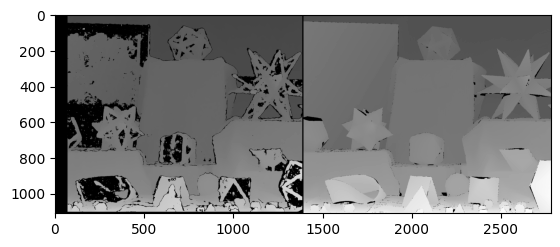

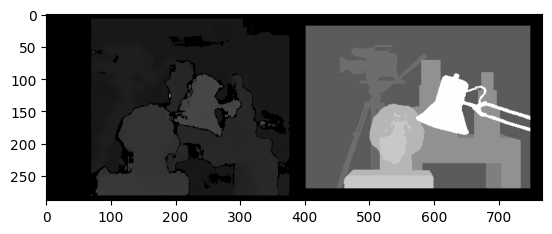

In [2]:
# Read images
moebius_image1 = cv2.imread("data/moebius1.png")
moebius_image1_gray = cv2.cvtColor(moebius_image1, cv2.COLOR_BGR2GRAY)
moebius_image2 = cv2.imread("data/moebius2.png")
moebius_image2_gray = cv2.cvtColor(moebius_image2, cv2.COLOR_BGR2GRAY)
moebius_gt = cv2.imread("data/moebius_gt.png", cv2.IMREAD_GRAYSCALE)

tsukuba_image1 = cv2.imread("data/tsukuba1.jpg")
tsukuba_image1_gray = cv2.cvtColor(tsukuba_image1, cv2.COLOR_BGR2GRAY)
tsukuba_image2 = cv2.imread("data/tsukuba2.jpg")
tsukuba_image2_gray = cv2.cvtColor(tsukuba_image2, cv2.COLOR_BGR2GRAY)
tsukuba_gt = cv2.imread("data/tsukuba_gt.jpg", cv2.IMREAD_GRAYSCALE)


# Task 0: Visualize cv2 Results
stereo = cv2.StereoBM.create(numDisparities=64, blockSize=15)
moebius_disparity_cv2 = stereo.compute(moebius_image1_gray, moebius_image2_gray)
visualize_disparity_map(moebius_disparity_cv2, moebius_gt)
tsukuba_disparity_cv2 = stereo.compute(tsukuba_image1_gray, tsukuba_image2_gray)
visualize_disparity_map(tsukuba_disparity_cv2, tsukuba_gt)

In [6]:
import time
for i in range(tsukuba_gt.shape[0]):
    print(tsukuba_gt[i],i)
    time.sleep(0.1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [10]:
def compute_disparity_map_simple(ref_image, sec_image, window_size, disparity_range, matching_function):
    # 1. Simple Stereo System: image planes are parallel to each other
    # 2. For each row, scan all pixels in that row
    # 3. Generate a window for each pixel
    # 4. Search a disparity(d) in (min_disparity, max_disparity)
    # 5. Select the best disparity that minimize window difference between (row, col) and (row, col - d)
    
    rows, cols = ref_image.shape
    disparity_map = np.zeros_like(ref_image, dtype=np.float32)

    for row in range(window_size, rows - window_size):
        for col in range(window_size, cols - window_size):
            ref_window = ref_image[row - window_size:row + window_size + 1, col - window_size:col + window_size + 1]
            best_disparity = 0
            min_cost = float('inf')
            for d in range(disparity_range[0], disparity_range[1] + 1):
                sec_col = col - d
                if sec_col < window_size or sec_col >= cols - window_size:
                    continue
                sec_window = sec_image[row - window_size:row + window_size + 1, sec_col - window_size:sec_col + window_size + 1]
                if matching_function == 'SSD':
                    cost = np.sum((ref_window - sec_window) ** 2)
                elif matching_function == 'SAD':
                    cost = np.sum(np.abs(ref_window - sec_window))
                elif matching_function == 'normalized_correlation':
                    ref_normal = ref_window - np.mean(ref_window)
                    sec_normal = sec_window - np.mean(sec_window)
                    cost = -np.sum(ref_normal * sec_normal) / (np.sqrt(np.sum(ref_normal ** 2)) * np.sqrt(np.sum(sec_normal ** 2)) + 1e-6)
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = d
            disparity_map[row, col] = best_disparity
    return disparity_map

In [14]:
def simple_disparity(ref_image, second_image, gt_map):
    # 1. Change window size, disparity range and matching functions
    # 2. Report the disparity maps and running time
    
    window_sizes = [4, 5 ,6]  # Try different window sizes
    disparity_range = (0, ref_image.shape[1] // 2)  # Determine appropriate disparity range
    matching_functions = ['SSD', 'SAD', 'normalized_correlation']  # Try different matching functions
    matching_functions = ['SSD']
    # Generate disparity maps for different settings
    for window_size in window_sizes:
        for matching_function in matching_functions:
            disparity_map = compute_disparity_map_simple(ref_image, second_image, window_size, disparity_range, matching_function)
            visualize_disparity_map(disparity_map, gt_map)

In [ ]:
# This may run for a long time! 
simple_disparity(moebius_image1_gray, moebius_image2_gray, moebius_gt)

C:\Users\远垂\AppData\Local\Temp\ipykernel_23796\793471699.py:9: RuntimeWarning: invalid value encountered in divide
  return np.maximum(disparity_map, 0.0) / disparity_map.max()


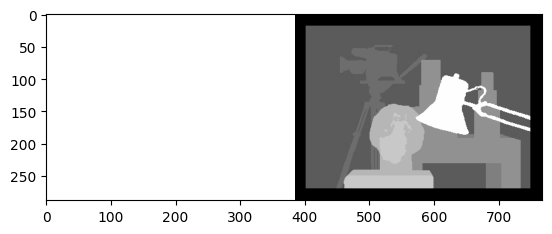

In [16]:
visualize_disparity_map(np.zeros_like(tsukuba_gt), tsukuba_gt)

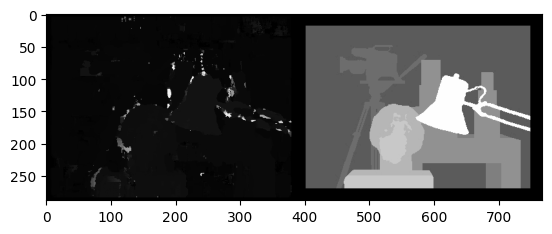

KeyboardInterrupt: 

In [15]:
# Task 1: Simple Disparity Algorithm
simple_disparity(tsukuba_image1_gray, tsukuba_image2_gray, tsukuba_gt)

In [ ]:
def compute_depth_map(disparity_map, baseline, focal_length):
    # 1. Compute depth map by z = fB / (x - x')
    depth_map = focal_length * baseline / (disparity_map + 1e-8)
    return depth_map

def visualize_pointcloud(ref_image, disparity_map):
    # 1. Calculate depth map from disparity
    # 2. Set pointcloud's XYZ as image's XY and depth
    # 3. Set pointcloud's color as ref_image
    # 4. Visualize pointcloud by trimesh, We recommend using MeshLab to open ply file
    # 6. Adjust the baseline and focal_length for better performance
    # 7. You may need to cut some outliers
    print(disparity_map)
    baseline = 10
    focal_length = 10
    depth_map = compute_depth_map(disparity_map, baseline, focal_length)
    rows, cols = ref_image.shape[:2]
    # Points
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    z = depth_map.flatten()
    points = np.column_stack((x.flatten(), y.flatten(), z))
    print(points)
    # Colors
    colors = ref_image.reshape(-1, 3) / 255.0
    # Save pointcloud as ply file
    pointcloud = trimesh.PointCloud(points, colors)
    pointcloud.export("pointcloud.ply", file_type="ply")

In [ ]:
for i in tsukuba_disparity_cv2:
    print(i)

[-16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16
 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -16 -1

In [ ]:
# Task 2: Compute depth map and visualize 3D pointcloud
# You can use the gt/cv2 disparity map first, then try your own disparity map
visualize_pointcloud(tsukuba_image1, tsukuba_disparity_cv2)
visualize_pointcloud(moebius_image1, moebius_disparity_cv2)


[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]
[[  0.     0.    -6.25]
 [  1.     0.    -6.25]
 [  2.     0.    -6.25]
 ...
 [381.   287.    -6.25]
 [382.   287.    -6.25]
 [383.   287.    -6.25]]
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]
[[ 0.000e+00  0.000e+00 -6.250e+00]
 [ 1.000e+00  0.000e+00 -6.250e+00]
 [ 2.000e+00  0.000e+00 -6.250e+00]
 ...
 [ 1.387e+03  1.109e+03 -6.250e+00]
 [ 1.388e+03  1.109e+03 -6.250e+00]
 [ 1.389e+03  1.109e+03 -6.250e+00]]
